# ECD-UY: Disaggregated energy consumption by appliance subset

This notebook presents the minimum code steps to load the subset and start to work with its records.

## Load libraries

In [1]:
# python
import datetime
from typing import List, Tuple, Union
import glob
from os.path import join, exists
from os import makedirs
import yaml
import warnings
from datetime import datetime, timedelta

# data-science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%pylab inline
%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 5]
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

print("Pandas version {}".format(pd.__version__))

Populating the interactive namespace from numpy and matplotlib
Pandas version 1.2.1


/Users/jp/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['datetime']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Declare the path where the files are located

In [2]:
BASE_DATA_SOURCE = "../../../datasets/ECD-UY/disaggregated-by-appliance-subset"

## Load customers data

In [3]:
data_customers = pd.read_csv(
    BASE_DATA_SOURCE + '/customers.csv',
)

display(data_customers)

,customer_id,tension,tariff,power,department,section,segment,zone
0,2,BT 230 V,TCB,3700,3,5,4,19
1,3,BT 230 V,TRS,2200,3,4,14,7
2,5,BT 230 V,TRS,2200,13,3,303,19
3,6,BT 230 V,TCB,3700,19,1,124,800
4,9,BT 230 V,TCB,3700,15,8,302,600
...,...,...,...,...,...,...,...,...
110988,170004,BT 230 V,TRS,3600,1,18,223,4
110989,170005,BT 230 V,TRS,3600,3,37,443,95
110990,170006,BT 230 V,TRS,3600,1,24,216,9
110991,170007,BT 230 V,TRS,3600,1,10,226,12


## Load appliances information data

In [4]:
data_appliances = pd.read_csv(
    BASE_DATA_SOURCE + '/appliances.csv',
)

data_appliances.head()

,customer_id,meter_id,appl_desc,appl_type
0,170000,00124B0002CBAF2D,Desumificador (Tercer dormitorio),dehumidifier
1,170000,00124B0018D7080C,HOME_CONSUMPTION (Sala de estar),site meter
2,170001,00124B0002CBAC43,Microndas (Cocina),microwave
3,170001,00124B0002CBAD5E,Cocina eléctrica (Cocina),electric oven
4,170001,00124B0002CBAE00,Lavarropa (Baño),washing machine


## Load appliances consumption data

In [5]:
data_appl_consum = pd.read_csv(
    BASE_DATA_SOURCE + '/appliance_consumption_data.csv',
)

data_appl_consum.head()

,datetime,meter_id,aenergy,apower,apower_ph1,apower_ph2,apower_ph3
0,1566943205,00124B0002CBABF1,2.0,120.0,120.0,0.0,0.0
1,1566943205,00124B0002CBAC13,0.0,0.0,0.0,0.0,0.0
2,1566943205,00124B0002CBAC43,0.0,0.0,0.0,0.0,0.0
3,1566943205,00124B0002CBAC6D,0.0,1.0,1.0,0.0,0.0
4,1566943205,00124B0002CBACAF,0.0,0.0,0.0,0.0,0.0


In [6]:
data_appl_consum["datetime"] = pd.to_datetime(
    data_appl_consum.datetime,
    unit='s',
    utc=True,
    cache=True
).dt.tz_convert('America/Montevideo')
data_appl_consum.head()

,datetime,meter_id,aenergy,apower,apower_ph1,apower_ph2,apower_ph3
0,2019-08-27 19:00:05-03:00,00124B0002CBABF1,2.0,120.0,120.0,0.0,0.0
1,2019-08-27 19:00:05-03:00,00124B0002CBAC13,0.0,0.0,0.0,0.0,0.0
2,2019-08-27 19:00:05-03:00,00124B0002CBAC43,0.0,0.0,0.0,0.0,0.0
3,2019-08-27 19:00:05-03:00,00124B0002CBAC6D,0.0,1.0,1.0,0.0,0.0
4,2019-08-27 19:00:05-03:00,00124B0002CBACAF,0.0,0.0,0.0,0.0,0.0


## Analize appliance consumption

### Quantify gaps

In [7]:
gaps_counter = pd.DataFrame(
    columns=["appl_meter_id", "appl_type", "num_gaps", "mean_gaps_len", "len", "count"],
)
gaps_counter.num_gaps = pd.to_numeric(gaps_counter.num_gaps)
gaps_counter.mean_gaps_len = pd.to_timedelta(gaps_counter.mean_gaps_len)
# {"appl_meter_id": str, "appl_type": str, "num_gaps": np.int16, "mean_gaps_len": datetime.timedelta}

def count_gaps(grp):
    grp_id = grp.meter_id.iloc[1]
    appl_type = data_appliances[data_appliances.meter_id == grp_id].appl_type.values[0]
    print("Appliance {} ({})".format(grp_id, appl_type))
    grp_diff = grp.datetime.diff()
    
    grp_min_dt = grp.datetime.min()
    grp_max_dt = grp.datetime.max()
    grp_len = grp_max_dt - grp_min_dt
    
    mask = grp_diff > pd.Timedelta('00:01:00')
    avg_gaps = grp_diff[mask].mean()
    num_gaps = mask[mask==True].shape[0]
    print("...have {} gaps with mean length {}".format(num_gaps, avg_gaps))
    global gaps_counter
    gaps_counter = gaps_counter.append(
        {
            "appl_meter_id": grp_id,
            "appl_type": appl_type,
            "num_gaps": num_gaps,
            "mean_gaps_len": avg_gaps,
            "len": grp_len,
            "count": 1,
        },
        ignore_index=True
    )

data_appl_consum.groupby(
    "meter_id"
).apply(count_gaps)

# display(gaps_counter)

td_mean = lambda x: x.sum()/x.count()
grp_count = lambda x: x.count()
display(
gaps_counter.groupby("appl_type")[["num_gaps", "mean_gaps_len", "len", "count"]].agg(
    {"num_gaps": mean, "mean_gaps_len": td_mean, "len": td_mean, "count": sum}
).sort_values("num_gaps", ascending=False)
)

Appliance 00124B0002CBABF1 (fridge)
...have 54 gaps with mean length 0 days 01:47:52.574074074
Appliance 00124B0002CBABF6 (electric water heating appliance)
...have 46 gaps with mean length 0 days 01:24:22.782608695
Appliance 00124B0002CBABFC (washing machine)
...have 68 gaps with mean length 0 days 05:09:40.588235294
Appliance 00124B0002CBAC13 (air conditioner)
...have 34 gaps with mean length 0 days 02:00:26.647058823
Appliance 00124B0002CBAC43 (microwave)
...have 51 gaps with mean length 0 days 01:17:16.549019607
Appliance 00124B0002CBAC6D (microwave)
...have 73 gaps with mean length 0 days 01:20:11.917808219
Appliance 00124B0002CBACAF (electric water heating appliance)
...have 74 gaps with mean length 0 days 01:19:12.527027027
Appliance 00124B0002CBACBB (electric water heating appliance)
...have 45 gaps with mean length 0 days 02:16:26.777777777
Appliance 00124B0002CBACEC (fridge)
...have 17 gaps with mean length 1 days 02:11:10.588235294
Appliance 00124B0002CBAD22 (fridge)
...have

,num_gaps,mean_gaps_len,len,count
appl_type,,,,
electric air heater,88.500000,0 days 01:50:59.078991038,19 days 19:05:00,2
electric oven,60.000000,0 days 01:07:33.066666666,19 days 19:05:00,1
tumble dryer,58.000000,0 days 01:40:46.844827586,19 days 19:05:02,1
washing machine,57.000000,0 days 02:17:09.274859753,19 days 16:07:59.800000,5
electric water heating appliance,53.800000,0 days 01:30:54.251853070,19 days 19:04:59.800000,5
microwave,52.250000,0 days 01:37:33.467197152,19 days 19:04:59.750000,4
fridge,40.600000,0 days 06:38:48.856937469,19 days 13:05:59.800000,5
dehumidifier,37.000000,0 days 03:25:36.135135135,18 days 04:41:58,1
air conditioner,36.666667,0 days 01:50:51.665395914,19 days 19:04:59,3


### Remove outliers

In [8]:
def filter_outliers(grp):
    upper_bound = grp[grp.apower > 0].apower.quantile(.99)
    grp.loc[grp.apower > upper_bound, "apower"] = 0
    return grp

data_appl_consum_filtered = data_appl_consum.groupby(
    "meter_id"
).apply(filter_outliers)#.drop(columns=["meter_id"]).reset_index()

display(data_appl_consum_filtered)

,datetime,meter_id,aenergy,apower,apower_ph1,apower_ph2,apower_ph3
0,2019-08-27 19:00:05-03:00,00124B0002CBABF1,2.0,120.0,120.0,0.0,0.0
1,2019-08-27 19:00:05-03:00,00124B0002CBAC13,0.0,0.0,0.0,0.0,0.0
2,2019-08-27 19:00:05-03:00,00124B0002CBAC43,0.0,0.0,0.0,0.0,0.0
3,2019-08-27 19:00:05-03:00,00124B0002CBAC6D,0.0,1.0,1.0,0.0,0.0
4,2019-08-27 19:00:05-03:00,00124B0002CBACAF,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
592683,2019-09-16 14:05:07-03:00,00124B0002CBABF1,2.0,113.0,113.0,0.0,0.0
592684,2019-09-16 14:05:07-03:00,00124B0002CBAC6D,4.0,1.0,1.0,0.0,0.0
592685,2019-09-16 14:05:07-03:00,00124B0002CBACAF,18.0,1075.0,1075.0,0.0,0.0
592686,2019-09-16 14:05:07-03:00,00124B0002CBAE49,0.0,0.0,0.0,0.0,0.0


### Resample to exactly one minute (and refill with zeros)

In [9]:
data_appl_consum_filtered = data_appl_consum_filtered.groupby(
    "meter_id"
).resample(
    "1min", on="datetime"
).max().fillna(0)
data_appl_consum_filtered = data_appl_consum_filtered.drop(columns=["datetime", "meter_id"]).reset_index()
display(data_appl_consum_filtered)

,meter_id,datetime,aenergy,apower,apower_ph1,apower_ph2,apower_ph3
0,00124B0002CBABF1,2019-08-27 19:00:00-03:00,2.0,120.0,120.0,0.0,0.0
1,00124B0002CBABF1,2019-08-27 19:01:00-03:00,2.0,120.0,120.0,0.0,0.0
2,00124B0002CBABF1,2019-08-27 19:02:00-03:00,2.0,119.0,119.0,0.0,0.0
3,00124B0002CBABF1,2019-08-27 19:03:00-03:00,2.0,119.0,119.0,0.0,0.0
4,00124B0002CBABF1,2019-08-27 19:04:00-03:00,2.0,118.0,118.0,0.0,0.0
...,...,...,...,...,...,...,...
764674,00124B0002CC9051,2019-09-16 14:01:00-03:00,0.0,0.0,0.0,0.0,0.0
764675,00124B0002CC9051,2019-09-16 14:02:00-03:00,0.0,0.0,0.0,0.0,0.0
764676,00124B0002CC9051,2019-09-16 14:03:00-03:00,0.0,0.0,0.0,0.0,0.0
764677,00124B0002CC9051,2019-09-16 14:04:00-03:00,0.0,0.0,0.0,0.0,0.0


Text(0.5, 0, 'Time')

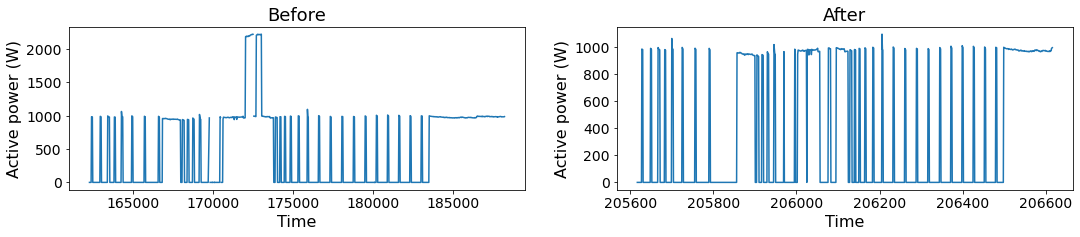

In [10]:
# Plot before and after

plt.rcParams['figure.figsize'] = [18, 3]
fig, axes = plt.subplots(nrows=1, ncols=2)

data_appl_consum[
    data_appl_consum.meter_id == "00124B0002CBACBB"
].iloc[6500:7500].apower.plot(
    ax=axes[0], fontsize=14,
#     ylabel="Active power (W)"
).set_title("Before", fontsize=18)
axes[0].set_ylabel("Active power (W)", fontsize=16)
axes[0].set_xlabel("Time", fontsize=16)
# axes[0].set_xticks([])

data_appl_consum_filtered[
    data_appl_consum_filtered.meter_id == "00124B0002CBACBB"
].iloc[6960:7960].apower.plot(
    ax=axes[1], fontsize=14,
#     ylabel="Active power (W)"
).set_title("After", fontsize=18)
axes[1].set_ylabel("Active power (W)", fontsize=16)
axes[1].set_xlabel("Time", fontsize=16)
# axes[1].set_xticks([])



### Plot hourly mean power demanded by appliance

In [11]:
# Calculate mean demand per hour for each appliance meter

df_appl_1h = data_appl_consum_filtered.groupby(
    "meter_id"
).resample(
    "1H", on="datetime"
).mean().reset_index().merge(
    data_appliances,
    left_on="meter_id",
    right_on="meter_id"
)

df_appl_1h.head(5)

,meter_id,datetime,aenergy,apower,apower_ph1,apower_ph2,apower_ph3,customer_id,appl_desc,appl_type
0,00124B0002CBABF1,2019-08-27 19:00:00-03:00,1.983333,118.150000,118.150000,0.0,0.0,170004,Heladera (Cocina),fridge
1,00124B0002CBABF1,2019-08-27 20:00:00-03:00,1.950000,109.450000,113.383333,0.0,0.0,170004,Heladera (Cocina),fridge
2,00124B0002CBABF1,2019-08-27 21:00:00-03:00,1.933333,114.683333,114.683333,0.0,0.0,170004,Heladera (Cocina),fridge
3,00124B0002CBABF1,2019-08-27 22:00:00-03:00,1.900000,113.983333,113.983333,0.0,0.0,170004,Heladera (Cocina),fridge
4,00124B0002CBABF1,2019-08-27 23:00:00-03:00,1.916667,114.366667,114.366667,0.0,0.0,170004,Heladera (Cocina),fridge


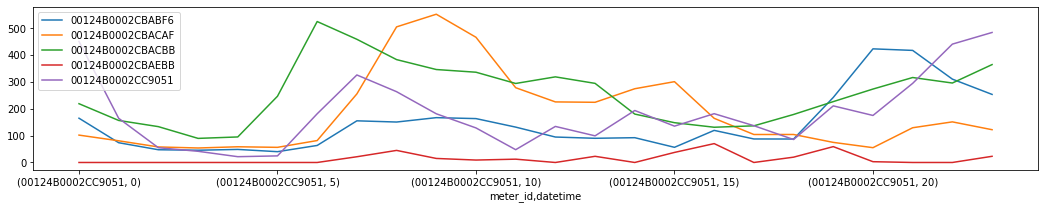

In [12]:
for i, grp in df_appl_1h[
    df_appl_1h.appl_type == "electric water heating appliance"
].groupby(["meter_id", df_appl_1h.datetime.dt.hour]).mean().groupby("meter_id"):
    grp.apower.plot(label=i)
plt.legend()

In [13]:
# Calculate mean demand per hour for each appliance type
df_appltype_1h = df_appl_1h.groupby(
    ["appl_type", df_appl_1h.datetime.dt.hour]
).mean()
df_appltype_1h = df_appltype_1h.reset_index()
display(df_appltype_1h)

,appl_type,datetime,aenergy,apower,apower_ph1,apower_ph2,apower_ph3,customer_id
0,air conditioner,0,0.931667,46.248889,54.513056,0.0,0.0,170006.666667
1,air conditioner,1,0.098611,5.305833,5.289167,0.0,0.0,170006.666667
2,air conditioner,2,0.014444,0.318611,0.307778,0.0,0.0,170006.666667
3,air conditioner,3,0.014444,0.339444,0.321944,0.0,0.0,170006.666667
4,air conditioner,4,0.014444,0.359722,0.343611,0.0,0.0,170006.666667
...,...,...,...,...,...,...,...,...
211,washing machine,19,0.006061,0.072222,0.073401,0.0,0.0,170004.979798
212,washing machine,20,0.226094,12.042088,12.866667,0.0,0.0,170004.979798
213,washing machine,21,0.040741,1.946465,2.058418,0.0,0.0,170004.979798
214,washing machine,22,0.100673,5.659428,5.660606,0.0,0.0,170004.979798


In [14]:
df_appltype_1h["appl_type"] = np.where(df_appltype_1h.appl_type == "electric water heating appliance", "electric water heater", df_appltype_1h.appl_type)

In [15]:
df_appltype_1h.appl_type.unique()

array(['air conditioner', 'dehumidifier', 'electric air heater',
       'electric oven', 'electric water heater', 'fridge', 'microwave',
       'tumble dryer', 'washing machine'], dtype=object)

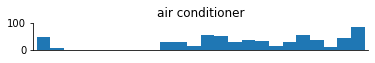

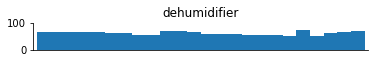

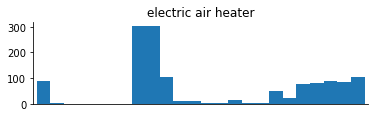

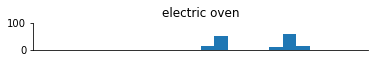

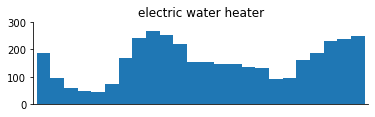

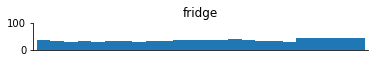

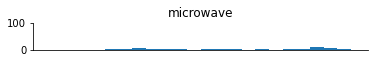

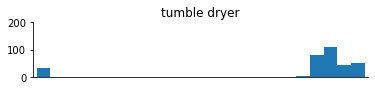

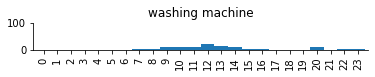

In [16]:
# plt.rcParams['figure.figsize'] = [6, 2]
import math
appl_types = df_appltype_1h.appl_type.unique()
for i,appl_t in enumerate(appl_types):
    x = df_appltype_1h[df_appltype_1h.appl_type==appl_t].datetime
    y = df_appltype_1h[df_appltype_1h.appl_type==appl_t].apower.values
    
    # Calculate heigh of the graph box
    max_cent = min(3, math.ceil(y.max() / 100))
    # print(max_cent)
    
    ax = pd.DataFrame(y, index=x).plot.bar(title=appl_t, align='center', width=1, figsize=(6,max_cent/2))
    ax.xlabel=""
    ax.legend=False
    ax.get_legend().remove()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.xlabel("")
    # Print y labels only in the last plot
    plt.yticks(list(range(0, (max_cent+1)*100, 100)))
    if i < len(appl_types)-1:
        plt.xticks([])

### Plot daily energy consumption per appliance

datetime       2.484000e+03
aenergy        1.532202e+02
apower         8.706078e+03
apower_ph1     9.096442e+03
apower_ph2     0.000000e+00
apower_ph3     0.000000e+00
customer_id    3.672084e+07
dtype: float64
{'air conditioner': 595.0032602339181, 'dehumidifier': 1473.4265410146986, 'electric air heater': 1346.0826096491228, 'electric oven': 147.3456140350877, 'electric water heater': 3788.3695, 'fridge': 854.5975606261825, 'microwave': 57.54744517543859, 'tumble dryer': 321.6666666666667, 'washing machine': 122.03843709020025}


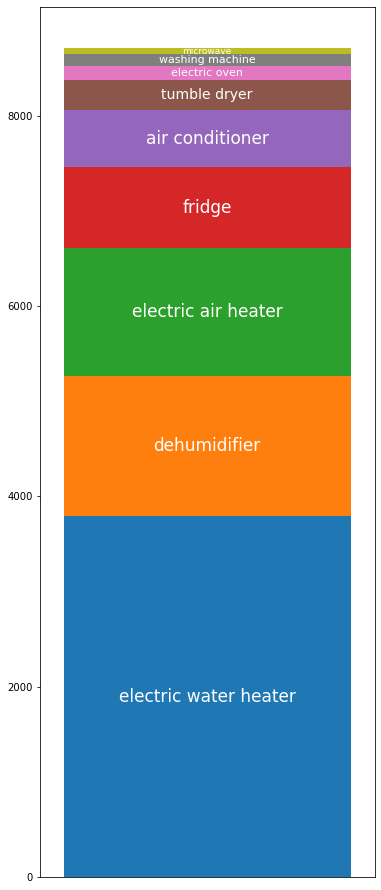

In [17]:
# Process daily consumption
plt.rcParams['figure.figsize'] = [6, 16]
df_appl_accum = df_appltype_1h.groupby("appl_type").sum()
print(df_appl_accum.sum())
print({appl_t: df_appl_accum.apower[appl_t] for appl_t in appl_types})

df_appl_accum = df_appl_accum.sort_values("apower", ascending=False)
appl_types = df_appl_accum.index.values

ax = pd.DataFrame(
    {appl_t: df_appl_accum.apower[appl_t] for appl_t in appl_types}, index=[0]
).plot(
    stacked=True,
    kind='bar',
    width=3
)

plt.xlabel("")
ax.get_legend().remove()
plt.xticks([])
for idx,rect in enumerate(ax.patches):
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    
    label_x = x + width -1.5  # adjust 0.2 to center the label
    label_y = y + height / 2
    ax.text(
        label_x, label_y,
        appl_types[idx], ha='center', va='center',
#         fontsize=12,
        fontsize=max(8, min(17, int(height*0.017) + 9)),  # calculate fontsize starting from box height
        color="white"
    )
    

## Load total consumption data

In [18]:
data_total_consum = pd.read_csv(
    BASE_DATA_SOURCE + '/total_consumption_data.csv',
    parse_dates=["datetime"],
    infer_datetime_format=True,
)
data_total_consum.head()

,datetime,meter_id,aenergy,aenergy_ph1,aenergy_ph2,aenergy_ph3,renergy,renergy_ph1,renergy_ph2,renergy_ph3,...,current_ph1,current_ph2,current_ph3,pfactor,pfactor_ph1,pfactor_ph2,pfactor_ph3,voltage_ph1,voltage_ph2,voltage_ph3
0,1566943205,00124B0018D6F607,4.0,19830.0,0.0,0.0,0.0,4765.0,4.0,0.0,...,1.3,0.0,0.0,0.9,0.9,0.0,0.0,223.0,0.0,0.0
1,1566943205,00124B0018D6F752,4.0,29250.0,0.0,0.0,0.0,111554.0,0.0,1.0,...,1.2,0.0,0.0,0.8,0.8,0.0,0.0,230.0,0.0,0.0
2,1566943205,00124B0018D6F755,8.0,1845536.0,0.0,0.0,1.0,211591.0,0.0,0.0,...,2.4,0.0,0.0,0.8,0.8,0.0,0.0,215.0,0.0,0.0
3,1566943205,00124B0018D6FB1E,3.0,12563.0,0.0,0.0,1.0,58587.0,0.0,0.0,...,1.1,0.0,0.0,0.7,0.7,0.0,0.0,236.0,0.0,0.0
4,1566943206,00124B0018D7080C,0.0,0.0,0.0,0.0,0.0,15979.0,89.0,5.0,...,0.2,0.0,0.0,-0.3,-0.3,0.0,0.0,233.0,0.0,0.0


In [19]:
data_total_consum["datetime"] = pd.to_datetime(
    data_total_consum.datetime,
    unit='s',
    utc=True,
    cache=True
).dt.tz_convert('America/Montevideo')
data_total_consum.head()

,datetime,meter_id,aenergy,aenergy_ph1,aenergy_ph2,aenergy_ph3,renergy,renergy_ph1,renergy_ph2,renergy_ph3,...,current_ph1,current_ph2,current_ph3,pfactor,pfactor_ph1,pfactor_ph2,pfactor_ph3,voltage_ph1,voltage_ph2,voltage_ph3
0,2019-08-27 19:00:05-03:00,00124B0018D6F607,4.0,19830.0,0.0,0.0,0.0,4765.0,4.0,0.0,...,1.3,0.0,0.0,0.9,0.9,0.0,0.0,223.0,0.0,0.0
1,2019-08-27 19:00:05-03:00,00124B0018D6F752,4.0,29250.0,0.0,0.0,0.0,111554.0,0.0,1.0,...,1.2,0.0,0.0,0.8,0.8,0.0,0.0,230.0,0.0,0.0
2,2019-08-27 19:00:05-03:00,00124B0018D6F755,8.0,1845536.0,0.0,0.0,1.0,211591.0,0.0,0.0,...,2.4,0.0,0.0,0.8,0.8,0.0,0.0,215.0,0.0,0.0
3,2019-08-27 19:00:05-03:00,00124B0018D6FB1E,3.0,12563.0,0.0,0.0,1.0,58587.0,0.0,0.0,...,1.1,0.0,0.0,0.7,0.7,0.0,0.0,236.0,0.0,0.0
4,2019-08-27 19:00:06-03:00,00124B0018D7080C,0.0,0.0,0.0,0.0,0.0,15979.0,89.0,5.0,...,0.2,0.0,0.0,-0.3,-0.3,0.0,0.0,233.0,0.0,0.0


<AxesSubplot:xlabel='datetime'>

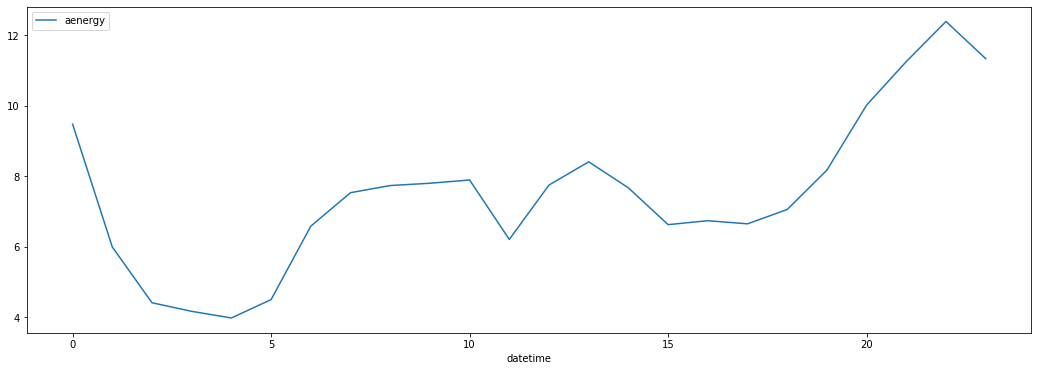

In [21]:
data_total_consum.groupby(data_total_consum.datetime.dt.hour).mean().plot(y="aenergy", figsize=(18, 6))